# NGBoost Example

**Goal:** Explore `ngboost` and understand the underlying API.

**Description:** `ngboost` is a package implementing NGBoost, a method to fit gradient boosting trees to the natural gradient. This allows for the fitting of probability distributions based on input features.

As an example, consider some input $\mathbf{x}$. Instead of the expected value $\mathbb{E}[y \mid \mathbf{x}]$, we are interested in modeling the entire distribution $\mathbb{P}[y \mid \mathbb{x}]$. Statistical methods allow for this, but analytical models are rare.

NGBoost can fit arbitrary distributions based on a "score" (in this case, we will only consider the negative log evidence).

In [1]:
from ngboost import NGBRegressor
from ngboost.distns import Normal
from ngboost.scores import LogScore

import numpy as np

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

I will use the Diabetes dataset from `sklearn`. The tutorial uses the Boston dataset, but this has since been deprecated due to ethical reasons. I will only use the third column for predictions to make plotting easier, but the method can handle arbitrarily many features.

In [3]:
data = load_diabetes()
X = data['data'][:, 2].reshape(-1, 1)
Y = data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

I will use the `NGBRegressor` class to fit the Normal (Gaussian) distribution to the data. The `LogScore` class implements the negative log evidence as the score, which is equivalent to performing maximum likelihood estimation of the parameters.

In [4]:
ngb = NGBRegressor(Dist=Normal, Score=LogScore).fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

[iter 0] loss=5.7740 val_loss=0.0000 scale=1.0000 norm=66.6668
[iter 100] loss=5.5309 val_loss=0.0000 scale=2.0000 norm=105.3888
[iter 200] loss=5.4273 val_loss=0.0000 scale=1.0000 norm=48.4133
[iter 300] loss=5.3712 val_loss=0.0000 scale=2.0000 norm=93.3430
[iter 400] loss=5.3201 val_loss=0.0000 scale=2.0000 norm=90.6379


Here, I report the root mean squared error (RMSE) and the negative log likelihood of the test data given the estimated distributions.

In [5]:
test_MSE = mean_squared_error(Y_preds, Y_test)
print(f'Test RMSE: {np.sqrt(test_MSE)}')

test_NLL = Y_dists.logpdf(Y_test).mean()
print(f'Test Mean Negative Log Likelihood (NLL): {test_NLL}')

Test RMSE: 60.65995051583359
Test Mean Negative Log Likelihood (NLL): -5.726454547520478


I can plot the mean of the distributions across the feature space. I can also show the extent of the estimated distributions by plotting two standard deviations from the normal distribution conditioned on the feature space.

Text(0.5, 1.0, 'Predicted Mean and Two Standard Deviations from X')

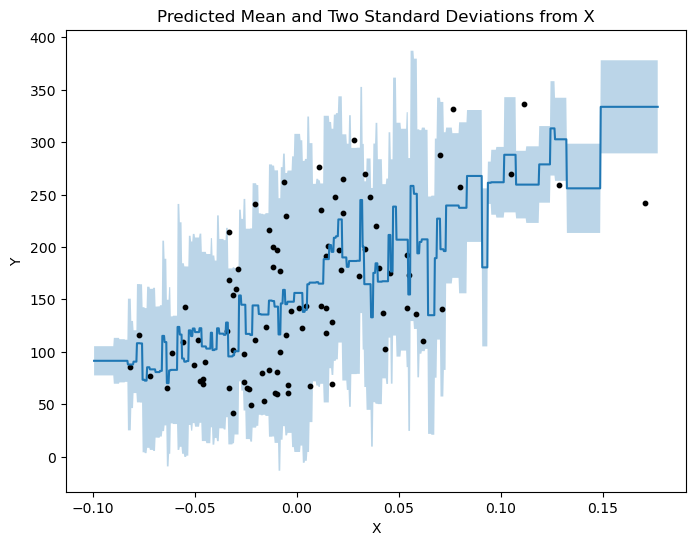

In [6]:
X_linspace = np.linspace(X_train.min() * 1.1, X_train.max() * 1.1, num=1000).reshape(-1, 1)
Y_plot = ngb.predict(X_linspace)
Y_plot_dists = ngb.pred_dist(X_linspace)

two_sigma = Y_plot_dists.params['scale'] * 2

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(X_linspace, Y_plot)
ax.fill_between(X_linspace.flatten(), Y_plot - two_sigma, Y_plot + two_sigma, alpha=0.3)
ax.scatter(X_test, Y_test, s=10, c='black')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Predicted Mean and Two Standard Deviations from X')

## Developing NGBoost

In addition to some prepackaged scores and distributions, the `ngboost` package can also be extended to support custom scores and distributions. This is exactly what Tony did, and I will explore this here.

In [25]:
import numpy as np

from scipy.stats import laplace

from ngboost.distns.distn import RegressionDistn
from ngboost.scores import LogScore

### Score

The score is implemented by extending the `LogScore` class in the tutorial. Therefore, we have to provide the negative log evidence (the score) and the derivative of the score in analytical form. All subclasses need to implement three methods:
1. `score()`: The value of the score at the current parameters, given the data `Y`.
2. `d_score()`: The derivative of the score at the current parameters, given the data `Y`.
3. `metric()`: The value of the Riemannian metric at the current parameters, which is the Fisher information matrix for the negative log evidence.

In [46]:
class LaplaceLogScore(LogScore):
    
    def score(self, Y):

        # NOTE: The LaplaceLogScore class does NOT have a distribution attribute.
        # This attribute comes from the Laplace class implemented above.
        # NGBoost automatically creates a dynamic class combining the score and the distribution.
        # Thus, attributes are accesible across the classes.
        return -self.distribution.logpdf(Y)
    
    def d_score(self, Y):
        
        # The derivative is calculated for each parameter based on the score derived for each data point.
        # Therefore, D is len(Y) by 2.
        if Y.shape:
            D = np.zeros((Y.shape[0], 2))
        else:
            D = np.zeros((len(Y), 2))

        D[:, 0] = np.sign(self.loc - Y) / self.scale
        D[:, 1] = 1 - np.abs(self.loc - Y) / self.scale

        return D

### Distribution

The distribution $\mathcal{D}$ is what we use to model the conditional probability of the outcomes. That is,

$$y \mid \mathbf{x} \sim \mathcal{D}(\boldsymbol\theta)$$

where $\boldsymbol\theta$ represents the parameters of the distribution. In `ngboost`, the support of the distribution can be discrete (and we extend `ClassificationDistn`) or continuous (and we extend `RegressionDistn`).
1. Any distribution implementation must extend the `fit()` and `sample()` methods.
2. A `score` attribute stores valid scores that can be used with this distribution.
3. The `n_params` attribute must specify the number of parameters for the distribution.
4. The distributional parameters must be stored in `_params`.
5. Regression distributions should specifically also implement a `mean()` method to make point predictions.


The tutorial for `ngboost` implements the Laplace distribution, which has the form

$$\mathcal{D}(y \mid \mu, b) = \frac{1}{2b} \exp\left( -\frac{1}{b} |y - \mu| \right)$$

with $\mu\in\mathbb{R}$ and $b\in\mathbb{R}^+$.

In [47]:
class Laplace(RegressionDistn):

    # Number of parameters (mu and b)
    n_params = 2
    scores = [LaplaceLogScore]

    def __init__(self, params):

        # Required internal representation of parameters
        # We will represent these as mu and log(b)
        self._params = params

        # Extract individual parameters
        self.loc = params[0]
        self.logscale = params[1]

        # Transform log(scale) to actual scale
        self.scale = np.exp(self.logscale)

        # Use SciPy's implementation of the laplace distribution
        self.distribution = laplace(loc=self.loc, scale=self.scale)

    def fit(Y):

        '''
        Fit the observations to the marginal distribution. In NGBoost, this is used to
        initialize the parameters before using boosting to better fit the data based on
        the gradients of the score.
        '''

        # Use SciPy's implementation to fit a Laplace distribution to Y
        m, s = laplace.fit(Y)
        return np.array([m, np.log(s)])
    
    def sample(self, m):

        '''
        Returns `m` samples from Pr(Y | X = x).
        '''

        return np.array([self.dist.rvs() for _ in range(m)])
    
    def __getattr__(self, name):

        '''
        Append all attributes of the distribution to this class.
        '''

        if name in dir(self.distribution):
            return getattr(self.distribution, name)
        
        return None
    
    @property
    def params(self):

        '''
        Return the parameters of this distribution.
        '''

        return {'loc': self.loc, 'scale': self.scale}

I will test this method on the same Diabetes dataset as above.

In [48]:
data = load_diabetes()
X = data['data'][:, 2].reshape(-1, 1)
Y = data['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [49]:
ngb = NGBRegressor(Dist=Laplace, Score=LaplaceLogScore).fit(X_train, Y_train)
Y_preds = ngb.predict(X_test)
Y_dists = ngb.pred_dist(X_test)

/Users/nikhil/micromamba/envs/genebayes/lib/python3.9/site-packages/ngboost/distns/distn.py:38: UserWarning: Using Dist=LaplaceLogScore is unnecessary. NGBoost automatically selects the correct implementation when LogScore or CRPScore is used
  warn(


ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (0,2,2)->(0,newaxis) (353,2)->(353,newaxis)  and requested shape (2)